In [1]:
import glob
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from tqdm.notebook import tqdm
from skbio.stats.distance import (permanova, permdisp)
from scipy.spatial import distance
from scipy.linalg import khatri_rao
from skbio import (DistanceMatrix, OrdinationResults)
from gemelli.ctf import ctf
from gemelli.joint_ctf import joint_ctf
from gemelli.preprocessing import clr_transformation

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (#accuracy_score, precision_score, recall_score, 
                             roc_curve, auc, average_precision_score)

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

In [117]:
def sub_feat_trajectory(table,
                        #individual_loadings,
                        feature_loadings, 
                        #temporal_loadings,
                        component, modality, zoom=True, 
                        quantile=0.95, pseudocount=0):
    # get the loadings
    #sloadings = individual_loadings[modality][component]
    floadings = feature_loadings[modality][component]
    #tloadings = temporal_loadings[modality][component]
    
    table_df = table.to_dataframe()

    if zoom:
        #get top and bottom loading quantiles
        top_q = floadings.quantile(quantile)
        bottom_q = floadings.quantile(1-quantile)
        top_fts = floadings[floadings >= top_q].index
        bottom_fts = floadings[floadings <= bottom_q].index
        
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount

        beta_l = np.log(num).values - np.log(denom).values
        beta_l = pd.DataFrame(beta_l, index=num.index, 
                              columns=[component])
    else:
        #calculate trajectories
        pass
        # y = []
        # for i, (individual_id, m) in enumerate(table.items()):
        #     y.append(np.concatenate(m.T.values))
        #     phi_ = phi_hat[ti[i]]
        #     new_m = np.outer(b_hat, phi_.T)
        #     new_m = a_hat[i] * new_m
        #     table_mod[individual_id] -= (lambda_coeff * new_m)
        #     residual_mod.append(table_mod[individual_id]**2)
        # residual_mod = np.sum(np.concatenate(residual_mod, axis=1))
        # y = np.concatenate(y)
        
    return beta_l, top_fts, bottom_fts

def temporal_trajectory(individual_loadings, 
                        feature_loadings,
                        temporal_loadings, 
                        state_column, modality, 
                        component = 'component_1',
                        f_subset=True, quantile=0.95):
    #get loadings
    sloadings = individual_loadings[modality][[component]].copy()
    floadings = feature_loadings[modality][[component]].copy()
    t_index = temporal_loadings[modality]['time_interval']
    tloadings = temporal_loadings[modality][[component]].copy()
    #add dummy column to all loadings
    sloadings['dummy'] = 1
    floadings['dummy'] = 1
    tloadings['dummy'] = 1

    #calculate the column-wise khatri-rao products
    #subject trajectory
    s_traj = khatri_rao(sloadings, tloadings)
    s_traj = pd.DataFrame(s_traj, columns=[component,'dummy'])
    #add subject IDs and resolution
    a_indexes_repeated = np.repeat(sloadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, sloadings.shape[0])
    s_traj['subjectID'] = a_indexes_repeated
    s_traj[state_column] = c_indexes_tiled
    
    #feature trajectory
    if f_subset:
        #get top and bottom loading quantiles
        top_q = floadings[component].quantile(quantile)
        bottom_q = floadings[component].quantile(1-quantile)
        top_fts = floadings[floadings[component] >= top_q].index.tolist()
        bottom_fts = floadings[floadings[component] <= bottom_q].index.tolist()
        floadings = floadings.loc[top_fts+bottom_fts]
        f_traj = khatri_rao(floadings, tloadings)
    else:
        f_traj = khatri_rao(floadings, tloadings)
    
    f_traj = pd.DataFrame(f_traj, columns=[component,'dummy'])
    #add feature IDs and resolution
    b_indexes_repeated = np.repeat(floadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, floadings.shape[0])
    f_traj['featureID'] = b_indexes_repeated
    f_traj[state_column] = c_indexes_tiled
    #if top/bottom features used, label them accordingly
    if f_subset:
        f_traj['quantile'] = ['top_q' if x in top_fts else 'bottom_q' for x in f_traj.featureID]

    #remove dummy columns
    s_traj.drop(columns=['dummy'], inplace=True)
    f_traj.drop(columns=['dummy'], inplace=True)
    return s_traj, f_traj

def plot_test_stats(data, x, hue, y_label='test statistic', 
                    title='Test Results', figsize=(12, 4)):

    fig, axn = plt.subplots(1, 2, figsize=figsize, sharey=False)
    sns.barplot(x=hue, y='test statistic', data=data, 
                ci=68, ax=axn[0])
    axn[0].set_facecolor('white')
    axn[0].set_xlabel(hue)
    axn[0].set_ylabel(y_label)
    sns.pointplot(x=x, hue=hue, y='test statistic', 
                  data=data, ci=68, ax=axn[1])
    axn[1].set_facecolor('white')
    axn[1].set_ylabel(y_label)
    plt.suptitle(title, fontsize=18)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [3]:
# load filtered tables
body_site = 'Baby-Feces'
mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
bt = load_table('../data/%s/table-filtered.biom' % body_site)

In [4]:
#remove CSseed babies
mf = mf[mf.birth_mode_ms != 'CSseed']
mf.birth_mode_ms.value_counts()

Vag    741
CS     366
Name: birth_mode_ms, dtype: int64

In [5]:
## overview of all columns
# for col in mf.columns:
#     print(col, '\n', mf[col].value_counts())
#     print()

In [5]:
# create mfs with different time points
mf_sub90 = mf[mf.date_sampling_category_days_continuous <= 90]
mf_sub200 = mf[mf.date_sampling_category_days_continuous <= 200]
mf_90plus = mf[mf.date_sampling_category_days_continuous >= 90]

In [13]:
# inits
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
#experiment = 'dispersion'
experiment = 'seq-depth'

# import simulations from file
if experiment == 'dispersion':
    seq_depth = 5000
    sims_dispersion = {(int(tbl_.split('/')[-1].split('-')[1]),
                        int(tbl_.split('/')[-1].split('-')[2]),
                        int(tbl_.split('/')[-1].split('-')[3].split('.')[0])):load_table(tbl_)
                        for tbl_ in glob.glob('../results/{}-tables/table-{}-*'.format(experiment, 
                                                                                       seq_depth))}

else:
    sims_depth = {(int(tbl_.split('/')[-1].split('-')[1]),
                    int(tbl_.split('/')[-1].split('-')[2].split('.')[0])):load_table(tbl_)
                    for tbl_ in glob.glob('../results/{}-tables/table-*'.format(experiment))}    

In [7]:
mf_to_use = mf.copy()  #options: mf, mf_sub90, mf_sub200, mf_90plus

#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep = mf_to_use[subject_id_column].value_counts()[mf_to_use[subject_id_column].value_counts() > 1].index
mf_to_use = mf_to_use[mf_to_use[subject_id_column].isin(ids_to_keep)]

In [14]:
#DEPTH:
sim_results_depth = {}
for k_sim, bt_tmp in tqdm(sims_depth.items()):
    print(k_sim)
    bt_tmp_clr = clr_transformation(bt_tmp, pseudocount=0.5)
    sim_results_depth[k_sim] = joint_ctf(tables=[bt_tmp_clr.copy()],
                                          sample_metadatas=[mf_to_use],
                                          modality_ids=['16S'],
                                          individual_id_column='subjectid_unique',
                                          state_column='date_sampling_category_days_continuous')
    print()

  0%|          | 0/12 [00:00<?, ?it/s]

(5000, 2)
Calculate components for component_1
Reached convergence in 12 iterations
Calculate components for component_2
Reached convergence in 12 iterations
Calculate components for component_3
Reached convergence in 14 iterations

(1000, 1)
Calculate components for component_1
Reached convergence in 21 iterations
Calculate components for component_2
Reached convergence in 17 iterations
Calculate components for component_3
Reached convergence in 21 iterations

(10000, 0)
Calculate components for component_1
Reached convergence in 10 iterations
Calculate components for component_2
Reached convergence in 10 iterations
Calculate components for component_3
Reached convergence in 13 iterations

(500, 1)
Calculate components for component_1
Reached convergence in 21 iterations
Calculate components for component_2
Reached convergence in 10 iterations
Calculate components for component_3
Reached convergence in 6 iterations

(500, 0)
Calculate components for component_1
Reached convergence in 

In [9]:
# #DISPERSION:
# sim_results_disp = {}
# for k_sim, bt_tmp in tqdm(sims_dispersion.items()):
#     print(k_sim)
#     bt_tmp_clr = clr_transformation(bt_tmp, pseudocount=0.5)
#     sim_results_disp[k_sim] = joint_ctf(tables=[bt_tmp_clr.copy()],
#                                           sample_metadatas=[mf_to_use],
#                                           modality_ids=['16S'],
#                                           individual_id_column='subjectid_unique',
#                                           state_column='date_sampling_category_days_continuous')
#     print()

In [15]:
cat_of_interest = 'birth_mode_ms'
experiment = 'depth' #'depth' or 'dispersion'
permanova_results = {}
permdisp_results = {}

for k_sim, (ind_loads, _, _, _, _, _) in tqdm(sim_results_depth.items()):
#for k_sim, (ind_loads, _, _, _, _, _) in tqdm(sim_results_disp.items()):
    
    ind_loads = ind_loads['16S']
    mf_tmp = mf_to_use.copy()
    mf_tmp.index = mf_tmp.subjectid_unique
    mf_tmp = mf_tmp.loc[ind_loads.index, :]
    
    for t_, t_mf in mf_tmp.groupby(state_column):

        # calculate distance for subjects
        dists = distance.cdist(ind_loads.values, ind_loads.values)
        dists = DistanceMatrix(dists, ids=ind_loads.index)
        dists.ids = list(map(str, dists.ids))
        dist_tmp_t = dists.copy().filter(t_mf.index)
        # MAKE SURE IT IS ORDERED CORRECTLY!
        t_mf = t_mf.reindex(dist_tmp_t.ids)
        # run test for homogeneity of multivariate groups dispersions
        permd = permdisp(dist_tmp_t, t_mf, column=cat_of_interest,
                         test='median', permutations=100)
        
        if experiment == 'dispersion':
            permdisp_results[(k_sim[0], k_sim[1], 
                              k_sim[2], t_)] = permd
            permanova_results[(k_sim[0], k_sim[1], 
                               k_sim[2], t_)] = permanova(dist_tmp_t, 
                                                          t_mf[cat_of_interest])
            
        else:
            permdisp_results[(k_sim[0], k_sim[1], t_)] = permd
            permanova_results[(k_sim[0], k_sim[1], t_)] = permanova(dist_tmp_t, 
                                                                    t_mf[cat_of_interest])

if experiment == 'dispersion':
    permanova_results_df = pd.DataFrame(permanova_results).T.reset_index()
    permanova_results_df = permanova_results_df.rename({'level_0':'depth',
                                                        'level_1':'dispersion',
                                                        'level_2':'simulation_fold',
                                                        'level_3':state_column}, axis=1)
    permdisp_results_df = pd.DataFrame(permdisp_results).T.reset_index()
    permdisp_results_df = permdisp_results_df.rename({'level_0':'depth',
                                                      'level_1':'dispersion',
                                                      'level_2':'simulation_fold',
                                                      'level_3':state_column}, axis=1)
else:
    permanova_results_df = pd.DataFrame(permanova_results).T.reset_index()
    permanova_results_df = permanova_results_df.rename({'level_0':'depth',
                                                        'level_1':'simulation_fold',
                                                        'level_2':state_column}, axis=1)
    permdisp_results_df = pd.DataFrame(permdisp_results).T.reset_index()
    permdisp_results_df = permdisp_results_df.rename({'level_0':'depth',
                                                      'level_1':'simulation_fold',
                                                      'level_2':state_column}, axis=1)

permanova_results_df['depth'] = permanova_results_df['depth'].astype(int)
display(permanova_results_df.head(5))
display(permdisp_results_df.head(5))

  0%|          | 0/12 [00:00<?, ?it/s]

,depth,simulation_fold,date_sampling_category_days_continuous,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
0,5000,2,0.0,PERMANOVA,pseudo-F,52,2,9.349415,0.001,999
1,5000,2,1.0,PERMANOVA,pseudo-F,60,2,5.968096,0.004,999
2,5000,2,2.0,PERMANOVA,pseudo-F,51,2,5.77413,0.004,999
3,5000,2,7.0,PERMANOVA,pseudo-F,86,2,10.084771,0.001,999
4,5000,2,14.0,PERMANOVA,pseudo-F,68,2,9.065062,0.001,999


,depth,simulation_fold,date_sampling_category_days_continuous,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
0,5000,2,0.0,PERMDISP,F-value,52,2,2.920633,0.09901,100
1,5000,2,1.0,PERMDISP,F-value,60,2,5.385918,0.029703,100
2,5000,2,2.0,PERMDISP,F-value,51,2,9.151044,0.009901,100
3,5000,2,7.0,PERMDISP,F-value,86,2,1.236744,0.356436,100
4,5000,2,14.0,PERMDISP,F-value,68,2,1.482832,0.29703,100


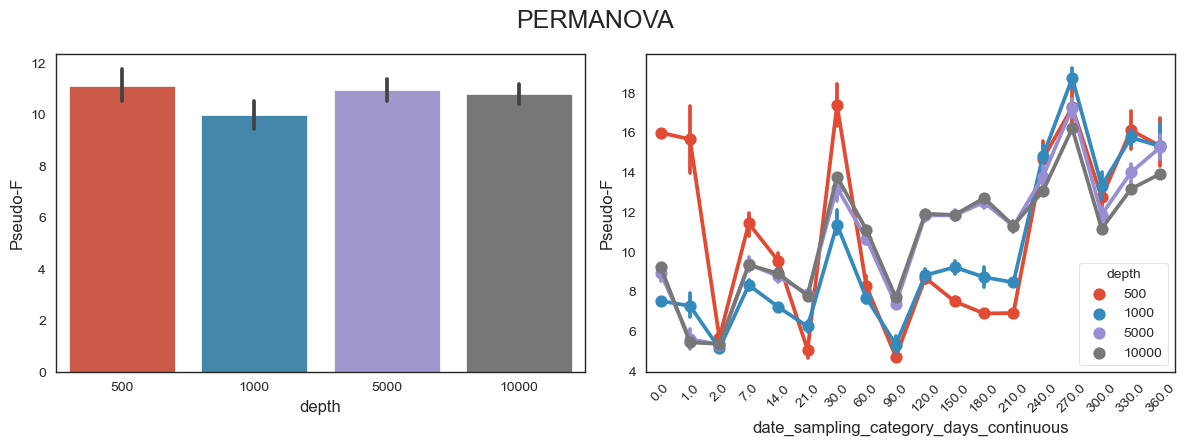

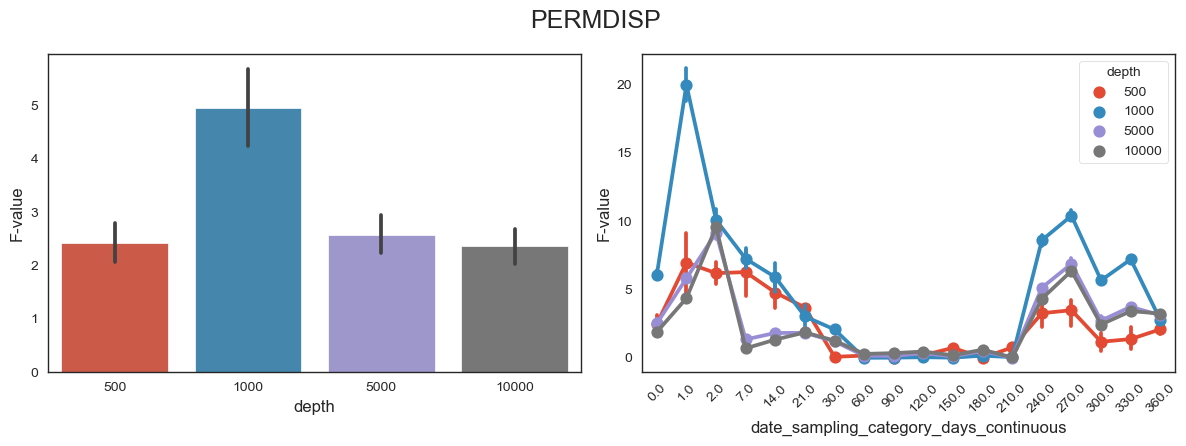

In [16]:
plot_test_stats(data=permanova_results_df, x=state_column, hue=experiment, 
                y_label='Pseudo-F', title='PERMANOVA', figsize=(12,4.5))

plot_test_stats(data=permdisp_results_df, x=state_column, hue=experiment,
                y_label='F-value', title='PERMDISP', figsize=(12,4.5))

PC1
Depth:  500
Eigenvalues:
      component_1  component_2  component_3
16S   855.872546   316.138186   249.455225

Explained variance:
                component_1  component_2  component_3
var_explained     0.672544     0.237188     0.090268

Depth:  1000
Eigenvalues:
      component_1  component_2  component_3
16S   981.533198   766.443579   301.318895

Explained variance:
                component_1  component_2  component_3
var_explained      0.52255     0.355298     0.122152

Depth:  5000
Eigenvalues:
      component_1  component_2  component_3
16S   804.621714   710.734361   403.784936

Explained variance:
                component_1  component_2  component_3
var_explained      0.47051      0.33335      0.19614

Depth:  10000
Eigenvalues:
      component_1  component_2  component_3
16S   827.406264   749.243232   458.088932

Explained variance:
                component_1  component_2  component_3
var_explained     0.464494     0.346869     0.188637



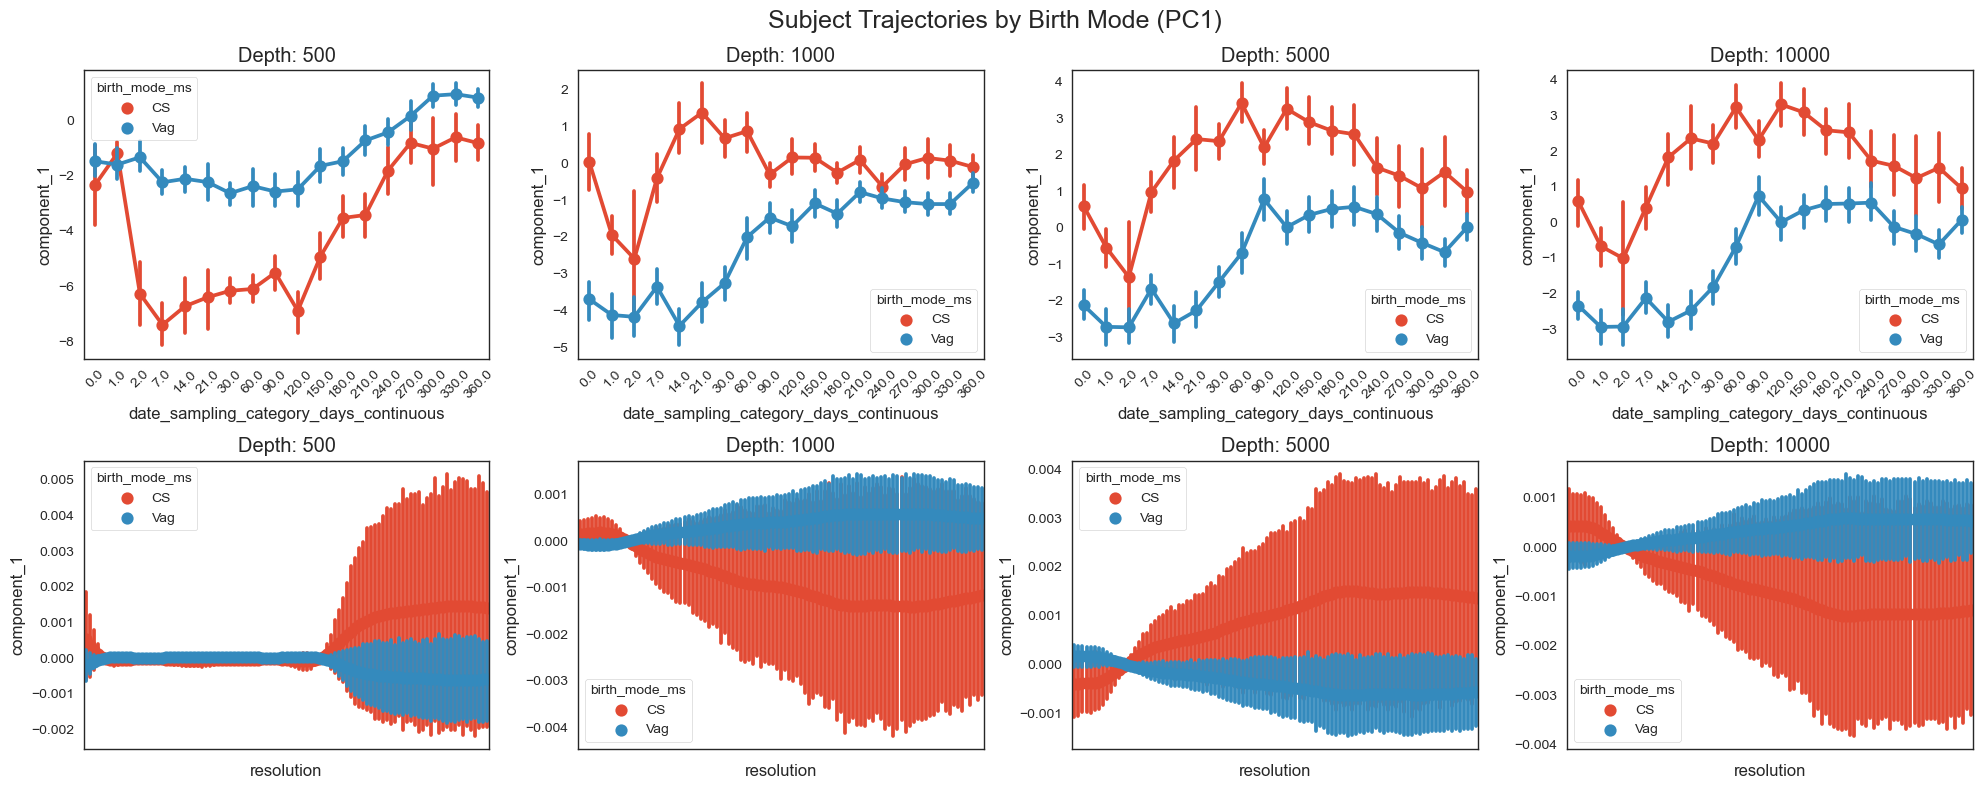

PC2
Depth:  500
Eigenvalues:
      component_1  component_2  component_3
16S   855.872546   316.138186   249.455225

Explained variance:
                component_1  component_2  component_3
var_explained     0.672544     0.237188     0.090268

Depth:  1000
Eigenvalues:
      component_1  component_2  component_3
16S   981.533198   766.443579   301.318895

Explained variance:
                component_1  component_2  component_3
var_explained      0.52255     0.355298     0.122152

Depth:  5000
Eigenvalues:
      component_1  component_2  component_3
16S   804.621714   710.734361   403.784936

Explained variance:
                component_1  component_2  component_3
var_explained      0.47051      0.33335      0.19614

Depth:  10000
Eigenvalues:
      component_1  component_2  component_3
16S   827.406264   749.243232   458.088932

Explained variance:
                component_1  component_2  component_3
var_explained     0.464494     0.346869     0.188637



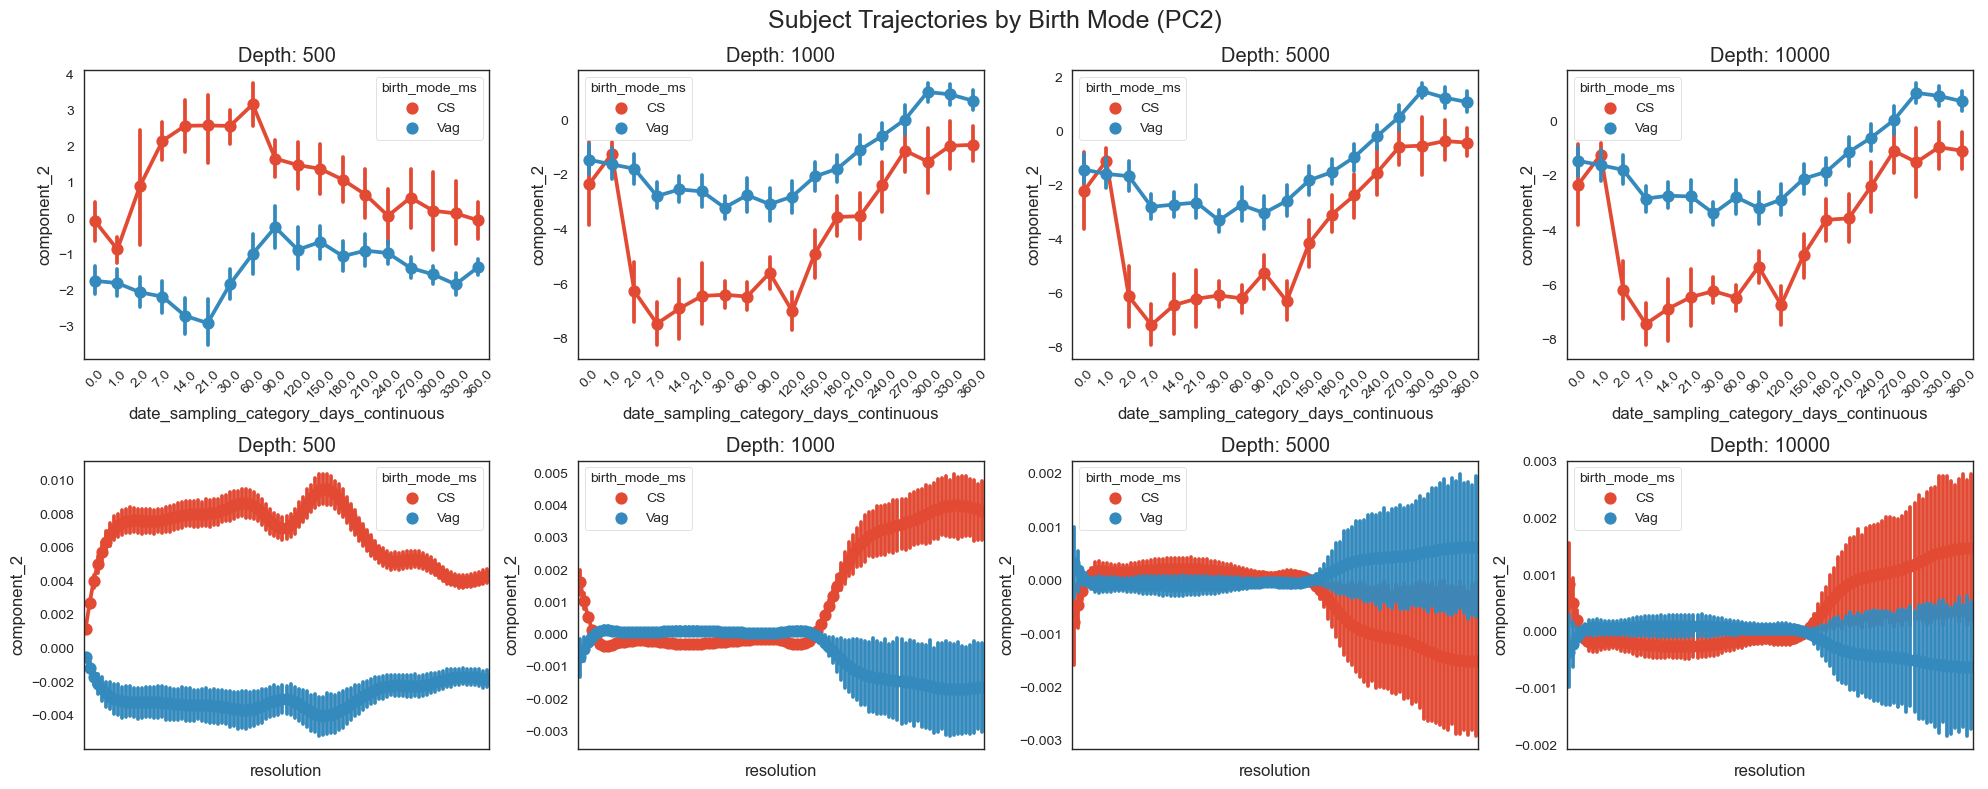

PC3
Depth:  500
Eigenvalues:
      component_1  component_2  component_3
16S   855.872546   316.138186   249.455225

Explained variance:
                component_1  component_2  component_3
var_explained     0.672544     0.237188     0.090268

Depth:  1000
Eigenvalues:
      component_1  component_2  component_3
16S   981.533198   766.443579   301.318895

Explained variance:
                component_1  component_2  component_3
var_explained      0.52255     0.355298     0.122152

Depth:  5000
Eigenvalues:
      component_1  component_2  component_3
16S   804.621714   710.734361   403.784936

Explained variance:
                component_1  component_2  component_3
var_explained      0.47051      0.33335      0.19614

Depth:  10000
Eigenvalues:
      component_1  component_2  component_3
16S   827.406264   749.243232   458.088932

Explained variance:
                component_1  component_2  component_3
var_explained     0.464494     0.346869     0.188637



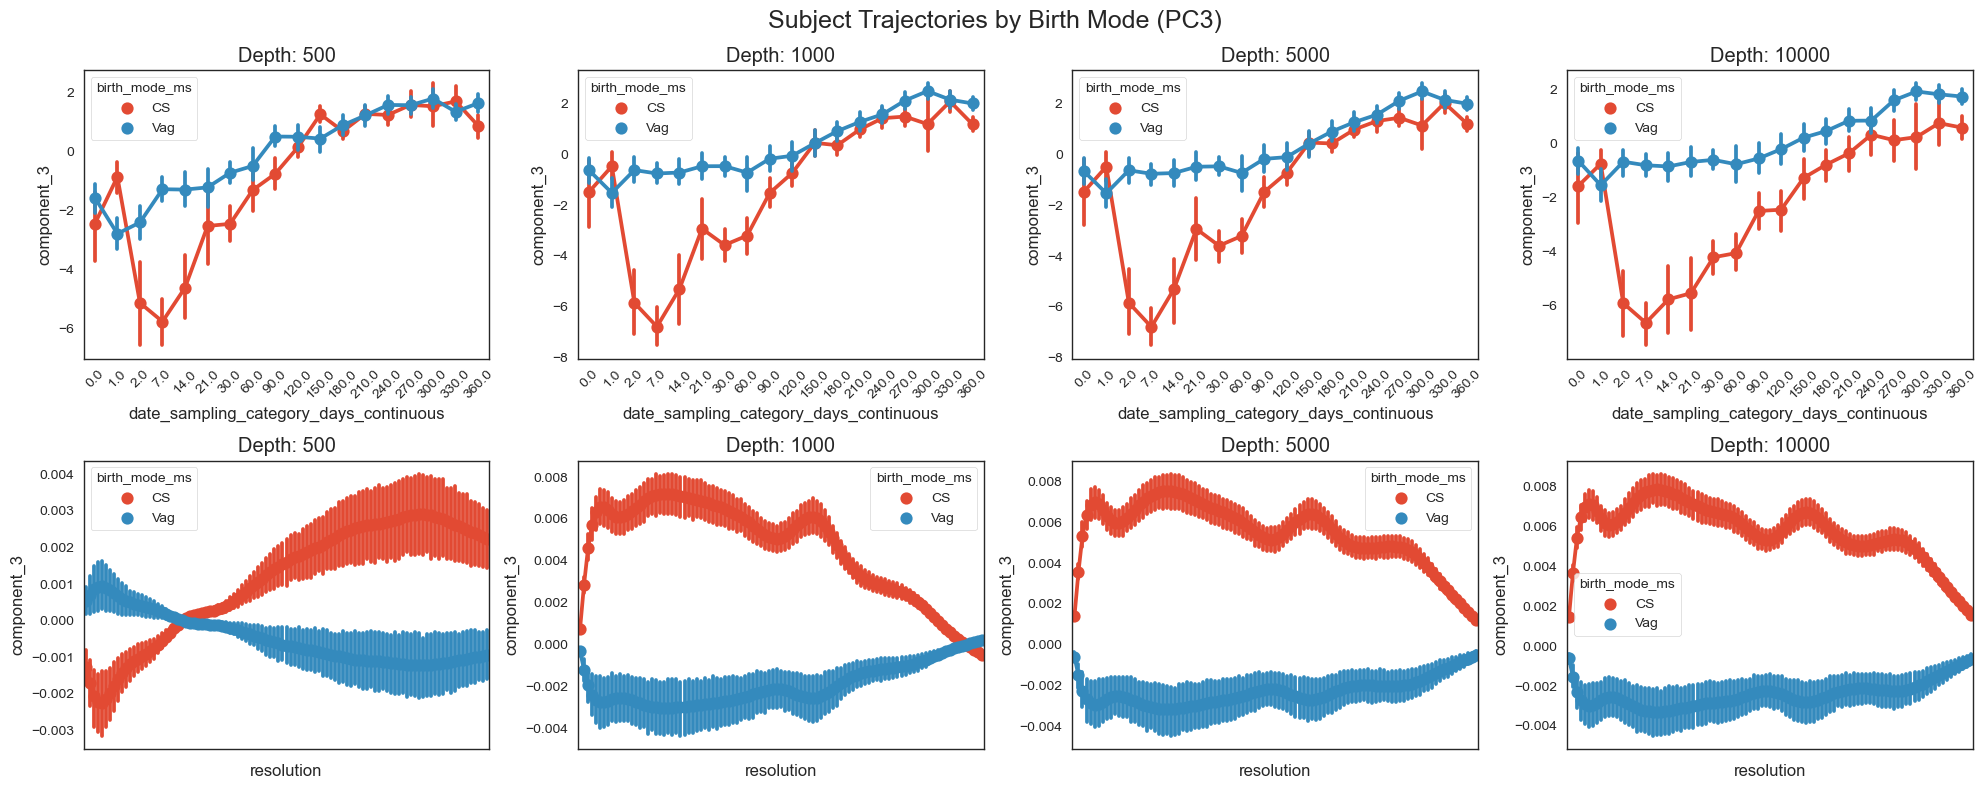

In [133]:
fold_ = 1
depth = 5000
test_title = 'Depth' #'Depth' or 'Dispersion'
state_column = 'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'

cols = sorted(set([int(k[0]) for k in sim_results_depth.keys()]))
#cols = sorted(set([int(k[1]) for k in sim_results_disp.keys()]))
mf_subject_collapsed = mf_to_use.groupby(subject_id_column).agg({cat_of_interest:'first'})

for ci, component in enumerate(['component_1', 'component_2', 'component_3']):
    
    fig, axn = plt.subplots(2, len(cols), figsize=(20, 8))
    
    print('PC{}'.format(ci+1))

    for i, exp_ in enumerate(cols):
        # (ind_loads, feat_loads, state_loads, 
        #  lambdas, var_explained, _) = sim_results_disp[(depth, exp_, fold_)]
        (ind_loads, feat_loads, state_loads, 
         lambdas, var_explained, _) = sim_results_depth[(exp_, fold_)]
        
        print('{}: '.format(test_title), exp_)
        print('Eigenvalues:\n', lambdas)
        print()
        print('Explained variance:\n', var_explained.T)
        print()
        #calculate trajectories based on log-ratio abundance
        beta_l, _, _ = sub_feat_trajectory(bt, feat_loads, component=component,
                                           modality='16S', pseudocount=0.5, quantile=0.95)
        #calculate trajectories based on khatri-rao product
        strajectory, ftrajectory = temporal_trajectory(ind_loads, feat_loads,
                                                       state_loads, modality='16S',
                                                       state_column='resolution',
                                                       component=component,
                                                       f_subset=True, quantile=0.95)
        #map dates and category of interest from mf
        beta_l[state_column] = beta_l.index.map(mf_to_use[state_column])
        beta_l[cat_of_interest] = beta_l.index.map(mf_to_use[cat_of_interest])
        strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_subject_collapsed[cat_of_interest])

        #plot trajectory #1
        sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                      data=beta_l, ax=axn[0,i], ci=68)
        axn[0,i].set_title('{}: {}'.format(test_title, exp_))
        axn[0,i].set_facecolor('white')
        xlabels = axn[0,i].get_xticklabels()
        axn[0,i].set_xticklabels(xlabels, rotation=45)
        #plot trajectory #2
        sns.pointplot(x='resolution', y=component, hue=cat_of_interest, 
                      data=strajectory, ax=axn[1,i], ci=68)
        axn[1,i].set_title('{}: {}'.format(test_title, exp_))
        axn[1,i].set_facecolor('white')
        #xlabels = axn[1,i].get_xticklabels()
        axn[1,i].set_xticklabels([], rotation=45)
        
    plt.suptitle('Subject Trajectories by Birth Mode (PC{})'.format(ci+1), fontsize=18)
    plt.tight_layout()
    plt.show()

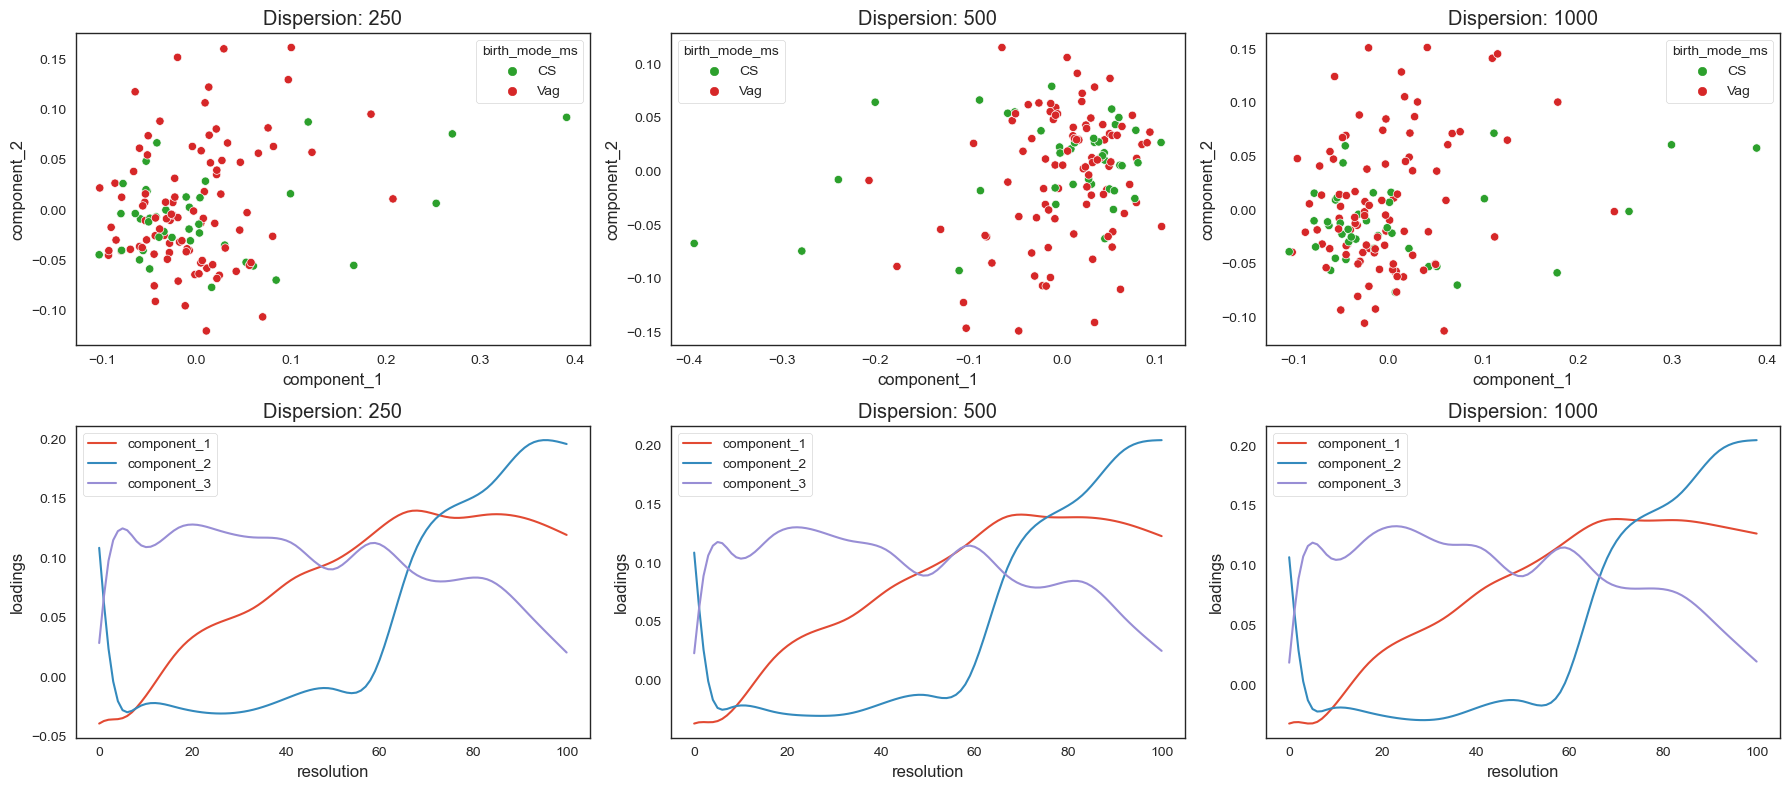

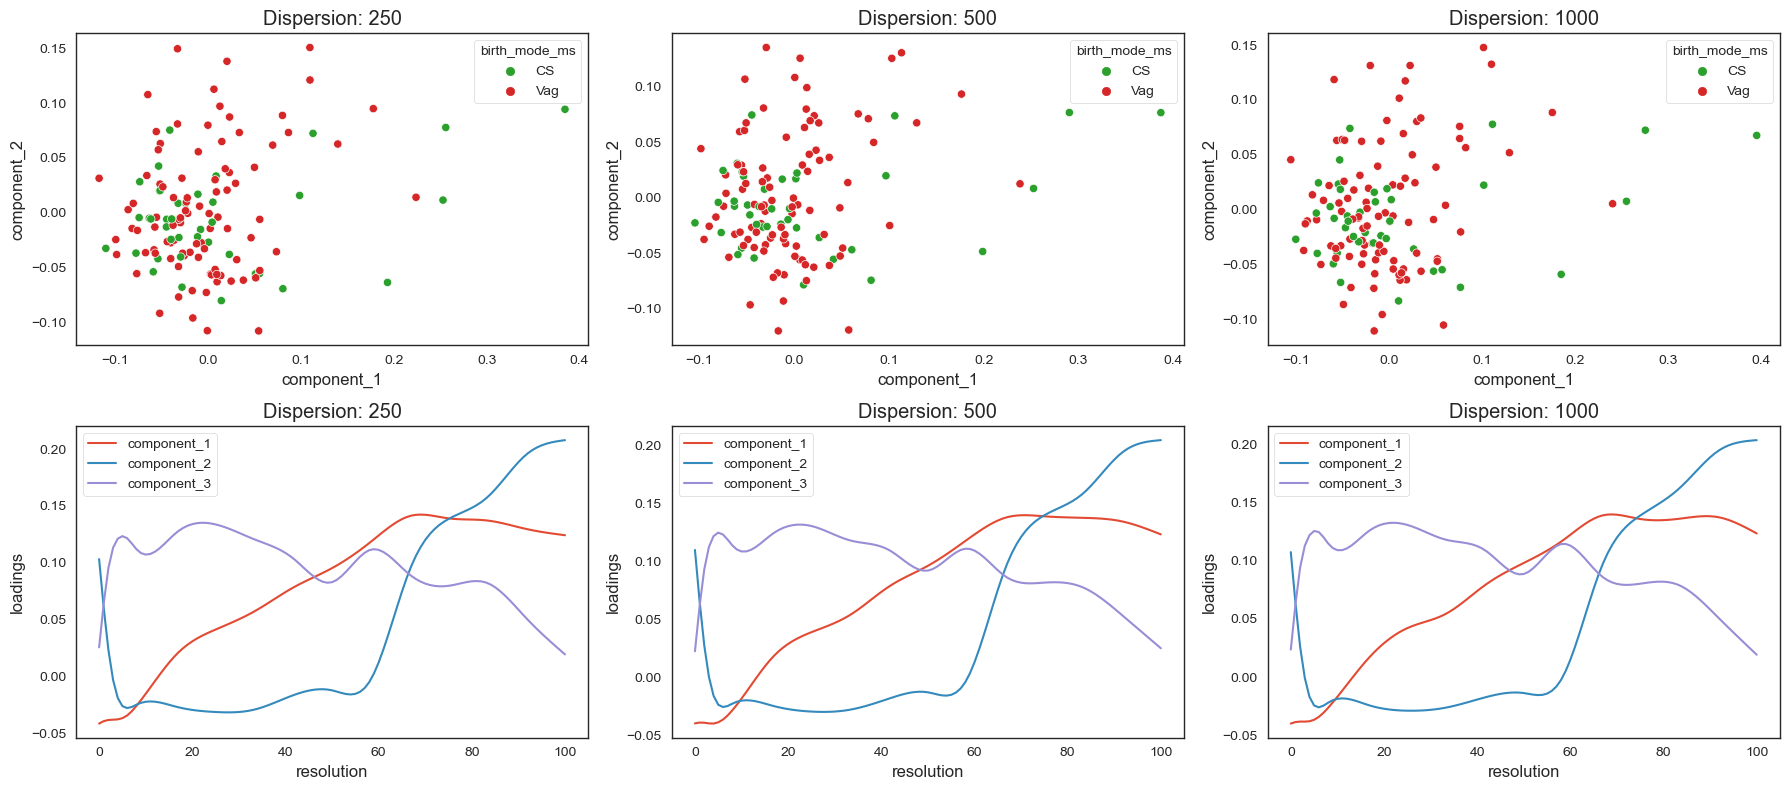

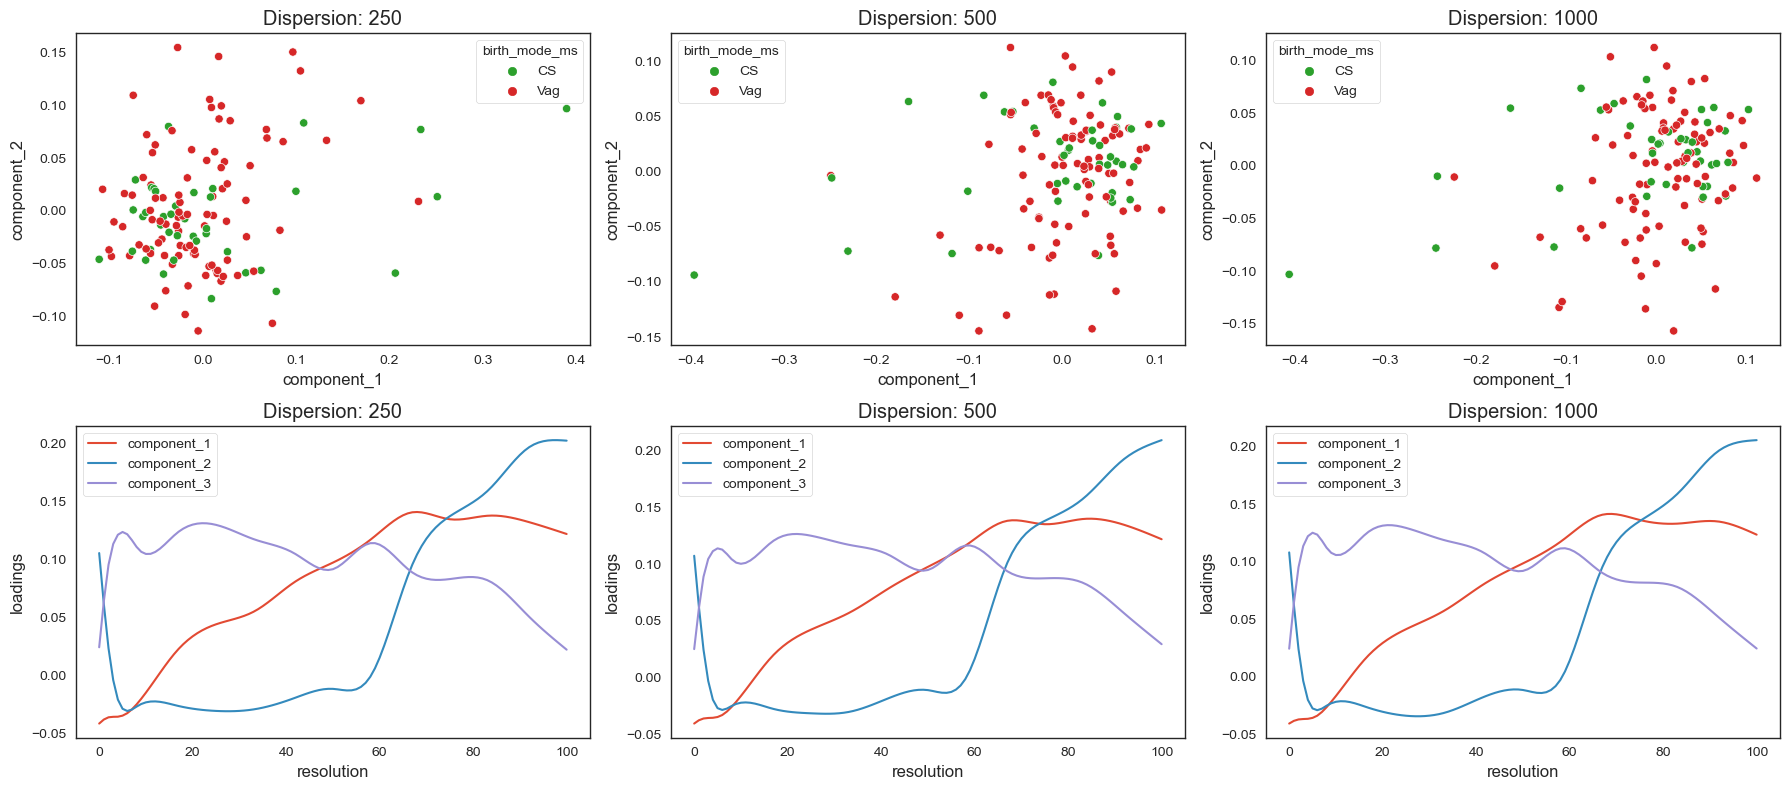

In [70]:
short_method_name = 'joint_ctf_biplot'
long_method_name = 'Individual level biplot'
group_colors = {'Vag': 'tab:red', 'CSseed': 'tab:blue', 'CS': 'tab:green'}
comp1 = 'component_1'
comp2 = 'component_2'
permdisp_res_subject = {}
experiment = 'dispersion' #'depth' or 'dispersion'
test_title = 'Dispersion'
 
sns.set_style('white')
for fold_ in range(3):

    #cols = sorted(set([int(k[0]) for k in sim_results_depth.keys()]))
    cols = sorted(set([int(k[1]) for k in sim_results_disp.keys()]))
    fig, axn = plt.subplots(2, len(cols), figsize=(18, 8))
    mf_subject_collapsed = mf_to_use.groupby(subject_id_column).agg({cat_of_interest:'first'})

    for i, exp in enumerate(cols):
        
        # (ind_loads, feat_loads, state_loads, 
        #  lambdas, var_explained, _) = sim_results_depth[(exp, fold_)]
        (ind_loads, feat_loads, state_loads, 
         lambdas, var_explained, _) = sim_results_disp[(depth, exp, fold_)]
        sns.scatterplot(x=ind_loads['16S'][comp1], 
                        y=ind_loads['16S'][comp2],  
                        hue=mf_subject_collapsed[cat_of_interest], 
                        palette=group_colors, ax=axn[0,i])
        axn[0,i].set_title('{}: {}'.format(test_title, exp))

        sns.lineplot(data=state_loads['16S'][['component_1', 'component_2', 'component_3']], 
                     ax=axn[1,i], dashes=False)
        axn[1,i].set_title('{}: {}'.format(test_title, exp))
        axn[1,i].legend() 
        axn[1,i].set_xlabel('resolution')         
        axn[1,i].set_ylabel('loadings') 

        #Get ordination results
        eigenvalues = lambdas.loc['16S']
        prop_explained  = var_explained['var_explained']
        ind_loads['16S'][comp1].index = ind_loads['16S'][comp1].index.astype(str)
        feat_loads['16S'].index = feat_loads['16S'].index.astype(str)
        individual_ord = OrdinationResults(short_method_name,
                                           long_method_name,
                                           eigenvalues,
                                           samples=ind_loads['16S'],
                                           features=feat_loads['16S'],
                                           proportion_explained=prop_explained)
        
        #perform permdist
        res = permdisp(individual_ord, mf_subject_collapsed, column=cat_of_interest,
                       test='median', permutations=100)
        permdisp_res_subject[(exp, fold_)] = res
    
    plt.tight_layout()
    plt.show()

permdisp_res_sub_df = pd.DataFrame(permdisp_res_subject).T.reset_index()
permdisp_res_sub_df = permdisp_res_sub_df.rename({'level_0':experiment,
                                                  'level_1':'simulation_fold'}, axis=1)  

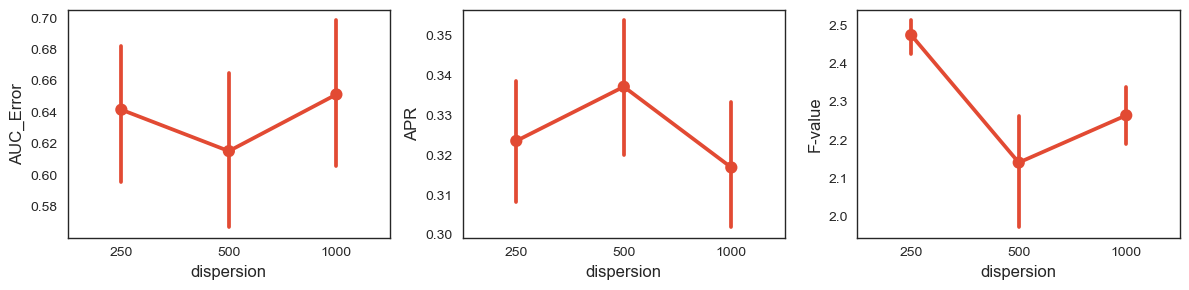

In [71]:
n_splits = 30
mf_subject_collapsed = mf_to_use.groupby(subject_id_column).agg({cat_of_interest:'first'})
#initialize df with metrics
metrics_df = pd.DataFrame(columns=['AUC_Error', 'APR', experiment])

for i, exp_ in enumerate(cols):
    ind_loads, _, _, _, _, _ = sim_results_disp[(depth, exp_, fold_)]
    #ind_loads, _, _, _, _, _ = sim_results_depth[(exp_, fold_)]

    #set up the classifier
    knn = KNeighborsClassifier(n_neighbors=2)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    X = ind_loads['16S'][['component_1', 'component_2', 'component_3']].copy()
    y = X.index.map(mf_subject_collapsed[cat_of_interest])
    X = X.values
    
    auc_error = []
    apr = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        y_proba = knn.predict_proba(X_test)

        #ROC AUC
        y_test_binary = [0 if x == "Vag" else 1 for x in y_test]
        fpr, tpr, _ = roc_curve(y_test_binary, y_proba[:,1])
        auc_error.append(1-auc(fpr, tpr))
        #APR
        apr.append(average_precision_score(y_test_binary, y_proba[:,1]))

    #create df with metrics
    metrics_df_iter = pd.DataFrame({'AUC_Error':auc_error, 'APR':apr}, index=range(n_splits))
    metrics_df_iter[experiment] = exp_

    #stack the metrics
    metrics_df = pd.concat([metrics_df, metrics_df_iter])

fig, axn = plt.subplots(1, 3, figsize=(12, 3))
sns.pointplot(x=experiment, y='AUC_Error', data=metrics_df, ax=axn[0], ci=68)
sns.pointplot(x=experiment, y='APR', data=metrics_df, ax=axn[1], ci=68)
sns.pointplot(x=experiment, y='test statistic', data=permdisp_res_sub_df, ax=axn[2], ci=68)
axn[2].set_ylabel('F-value')
plt.tight_layout()
plt.show()

In [ ]:
# simulation_results_ctf = {}
# for k_sim, bt_tmp in tqdm(simulations_depth.items()):
#     print(k_sim)
#     # run CTF (can re-filter to what you might do normally)
#     simulation_results_ctf[k_sim] = ctf(bt_tmp.copy(), mf, 
#                                         subject_id_column,
#                                         state_column,
#                                         min_sample_count=0)